In [2]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [3]:
from data_reader_writer import data_writer

import pypsa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

## System Transformation - 2021

In [3]:
# scenario = 'Leading The Way'
# scenario = 'Consumer Transformation'
scenario = 'System Transformation'
# scenario = 'Steady Progression'
year = 2021
year_baseline = 2012

start = str(year) + '-01-01 00:00:00'
end = str(year) + '-12-31 23:00:00'
# time step as fraction of hour
time_step = 1
data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
            scenario=scenario, FES=2022, merge_generators=True, scale_to_peak=True)

c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\arrays\datetimes.py:741: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  warnings.warn(
c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [4]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
       'Tidal lagoon Penwortham', 'Tidal lagoon S.W.Penisula',
       'Tidal stream Deeside', 'Tidal stream Harker', 'Tidal stream Lovedean',
       'Tidal stream Melksham', 'Tidal stream Penwortham',
       'Tidal stream S.W.Penisula', 'Wave power Beauly', 'Wave power Melksham',
       'Wave power Neilston'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, links, loads, storage_units


In [5]:
# scale the B6 lines to system transformation economy RT
B6 = network.lines.at['17', 's_nom'] + network.lines.at['18', 's_nom'] + network.lines.at['23', 's_nom'] + network.lines.at['24', 's_nom'] + network.lines.at['16', 's_nom']
# network.lines
scaling_factor = 6100 / B6
network.lines.s_nom *= scaling_factor

In [6]:
# need to remove the CCS Gas
network.generators = network.generators[~network.generators.carrier.str.contains('CCS Gas')]

In [7]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 59.12s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19
Read LP format model from file C:\Users\alyden\AppData\Local\Temp\pypsa-problem-8tyqxeip.lp
Reading time = 42.17 seconds
obj: 22109456 rows, 6753961 columns, 38919021 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 22109456 rows, 6753961 columns and 38919021 nonzeros
Model fingerprint: 0xc2b72dab
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 1e+09]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-06, 1e+09]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 20313670 rows and 1334185 columns (presolve time = 6s) ...
Presolve removed 20319570 rows and 2430000 columns (presolve time = 10s) ...
Presolve removed 20777950 rows and 2888380 columns (presolve time = 15s) ...
Presolve removed 20839263 r

INFO:pypsa.linopf:Optimization successful. Objective value: 3.06e+11


('ok', 'optimal')

In [8]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})

p_by_carrier

carrier,Biomass (co-firing),Biomass (dedicated),CCS Biomass,Coal,Hydrogen,Hydro,Natural Gas,Nuclear,Oil,Small Hydro,...,Unmet Load,Waste,Wave power,Wind Offshore,Wind Onshore,Battery,Compressed Air,Liquid Air,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,25.039,196.198512,0.0,0.0,0.0,265.206759,6930.818558,4998.381831,0.0,29.144050,...,0.0,0.0,0.79599,11845.494399,6384.528221,189.682635,0.075718,0.000000,0.000000,221.237512
2021-01-01 01:00:00,25.039,110.415493,0.0,0.0,0.0,336.464929,4630.193651,4998.381831,0.0,27.355812,...,0.0,0.0,0.72399,11428.639803,6010.209998,0.000000,0.000000,0.000000,0.000000,135.454493
2021-01-01 02:00:00,25.039,110.415493,0.0,0.0,0.0,248.740307,4397.327111,4959.823199,0.0,27.334522,...,0.0,0.0,0.72399,11385.263660,6222.951903,0.000000,0.000000,0.000000,0.000000,135.454493
2021-01-01 03:00:00,25.039,110.415493,0.0,0.0,0.0,399.830308,4442.255273,4887.915621,0.0,43.311077,...,0.0,0.0,0.72399,10970.059674,6805.108993,0.000000,0.000000,0.000000,0.000000,135.454493
2021-01-01 04:00:00,25.039,110.415493,0.0,0.0,0.0,410.260003,3159.861911,4847.017802,0.0,40.320550,...,0.0,0.0,0.72399,10492.588779,6640.730393,0.000000,0.000000,0.082086,0.000000,135.454493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,486.472,2041.825328,0.0,0.0,0.0,536.736012,13176.119500,4998.381831,0.0,51.709933,...,0.0,0.0,0.86001,12401.265023,5455.553822,363.817447,0.000000,0.000000,1117.936418,2528.297328
2021-12-31 20:00:00,25.039,456.045266,0.0,0.0,0.0,505.579250,15913.154465,4998.381831,0.0,48.708244,...,0.0,0.0,0.86001,11631.662733,5809.873578,512.555021,0.221703,0.097982,0.000000,481.084266
2021-12-31 21:00:00,25.039,437.958487,0.0,0.0,0.0,454.535190,13815.321888,4998.381831,0.0,43.790585,...,0.0,0.0,0.86001,10524.792577,5436.293681,248.279962,0.390117,0.591087,214.611204,462.997487


Text(0.5, 0, '')

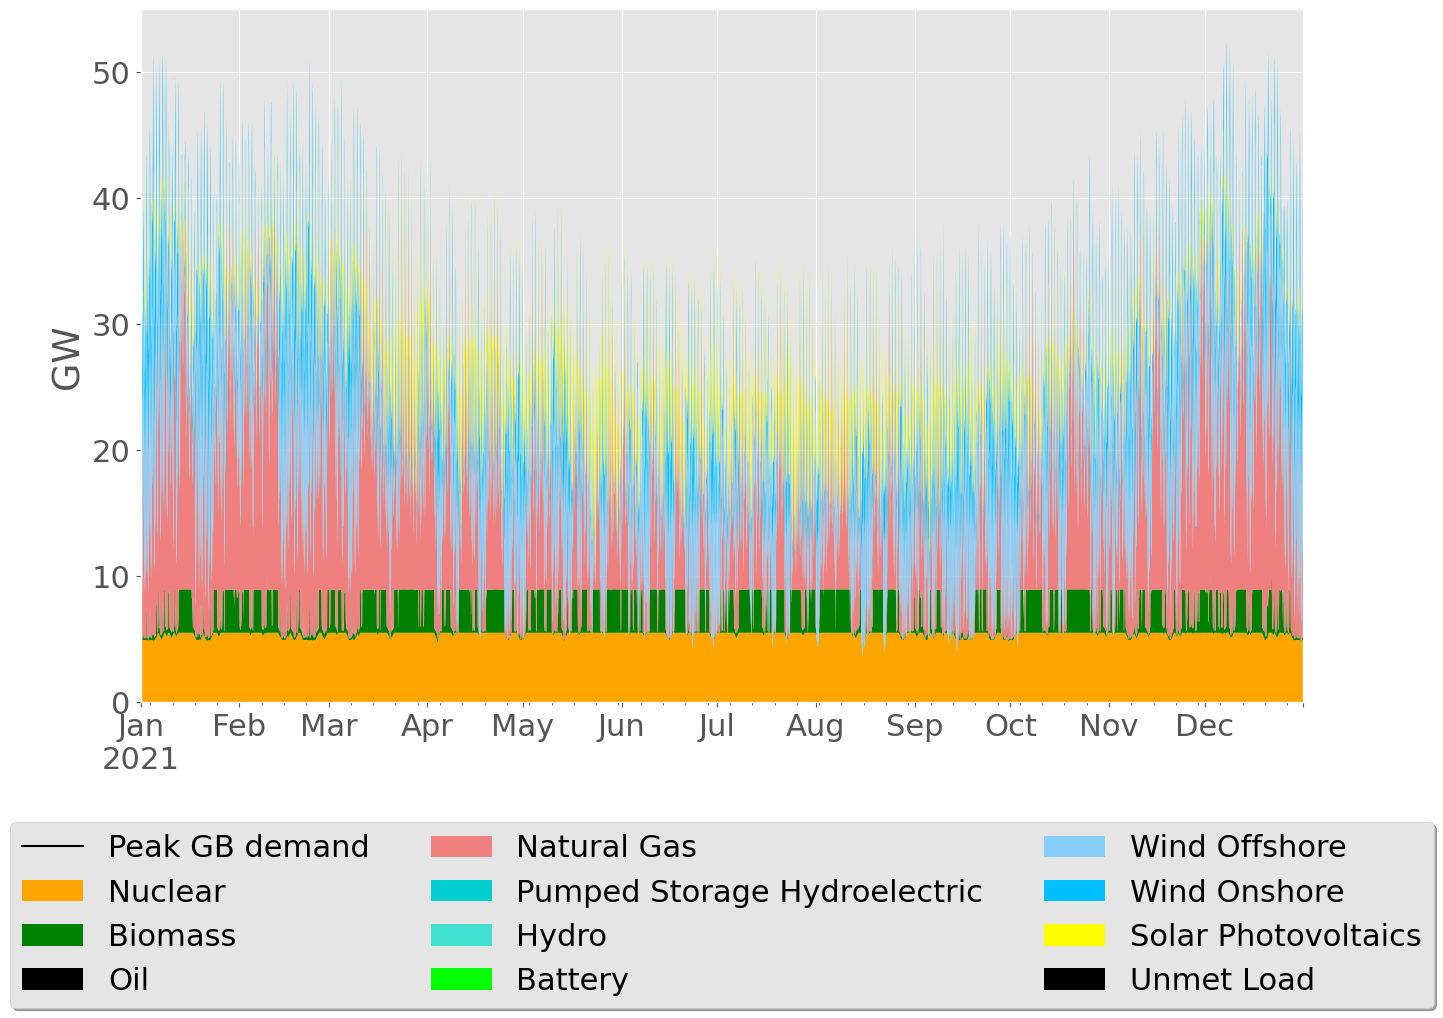

In [9]:
cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak GB demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

ax.set_ylabel("GW")

ax.set_xlabel("")

In [10]:

buses_scotland = ['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston', 'Strathaven', 'Torness', 'Eccles']
df_generators_scotland = network.generators[network.generators.bus.isin(buses_scotland)]
df_storage_scotland = network.storage_units[network.storage_units.bus.isin(buses_scotland)]

p_by_carrier_scotland = network.generators_t.p[df_generators_scotland.index.values].groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier_scotland = network.storage_units_t.p[df_storage_scotland.index.values].groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier_scotland[storage_by_carrier_scotland < 0] = 0

p_by_carrier_scotland = pd.concat([p_by_carrier_scotland, storage_by_carrier_scotland], axis=1)

In [11]:
network.lines_t.p0[['17', '18', '23', '24', '16']]
B6_to_scotland = network.lines_t.p0[['17', '18', '23', '24', '16']]

B6_import = B6_to_scotland.copy()
B6_export = B6_to_scotland.copy()

B6_import[B6_import > 0] = 0
B6_import = B6_import.sum(axis=1) * -1

B6_export[B6_export < 0] = 0
B6_export = B6_export.sum(axis=1) * -1
B6_export.name = 'B6 export'

snapshot
2021-01-01 00:00:00   -2823.709845
2021-01-01 01:00:00   -2759.222473
2021-01-01 02:00:00   -2726.997382
2021-01-01 03:00:00   -2722.757160
2021-01-01 04:00:00   -2716.600904
                          ...     
2021-12-31 19:00:00   -2761.711788
2021-12-31 20:00:00   -2706.857946
2021-12-31 21:00:00   -2804.481679
2021-12-31 22:00:00   -2884.000477
2021-12-31 23:00:00   -2907.126396
Name: B6 export, Length: 8760, dtype: float64


c:\Users\alyden\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\plotting\_matplotlib\core.py:1391: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


Text(0.5, 0, '')

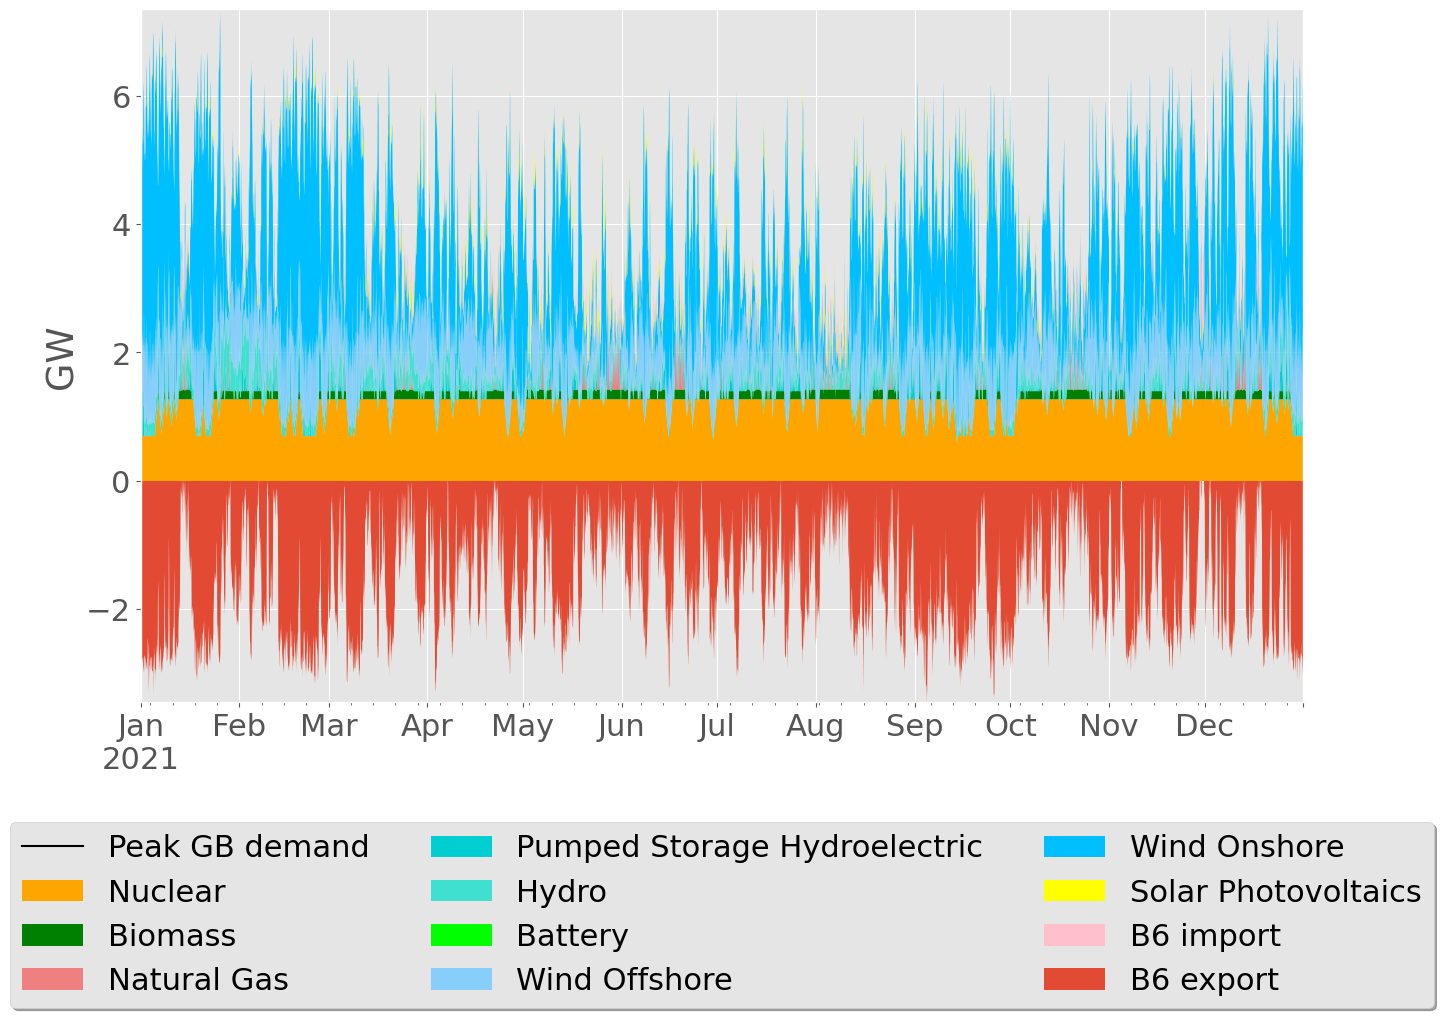

In [12]:
# group biomass stuff
p_by_carrier_scotland['Biomass'] = (
    p_by_carrier_scotland['Biomass (dedicated)'])

# add B6 flows
p_by_carrier_scotland['B6 import'] = B6_import

# rename the hydro bit
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier_scotland = p_by_carrier_scotland.rename(
    columns={'Interconnector': 'Interconnectors Import'})

cols = ["Nuclear", 'Biomass',
        'Waste', "Oil", "Natural Gas",
        'Hydrogen', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Unmet Load', 'B6 import'
        ]

p_by_carrier_scotland = p_by_carrier_scotland[cols]

p_by_carrier_scotland.drop(
    (p_by_carrier_scotland.max()[p_by_carrier_scotland.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          'B6 import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier_scotland / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier_scotland.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(B6_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
print(B6_export)
ax.set_ylim(B6_export.min() / 1e3, (p_by_carrier_scotland / 1e3).sum(axis=1).max())

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.axvline(x = '2045-12-07 20:00:00', color = 'black', label = 'Peak GB demand')
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
ax.set_ylabel("GW")

ax.set_xlabel("")


## Import and export analysis

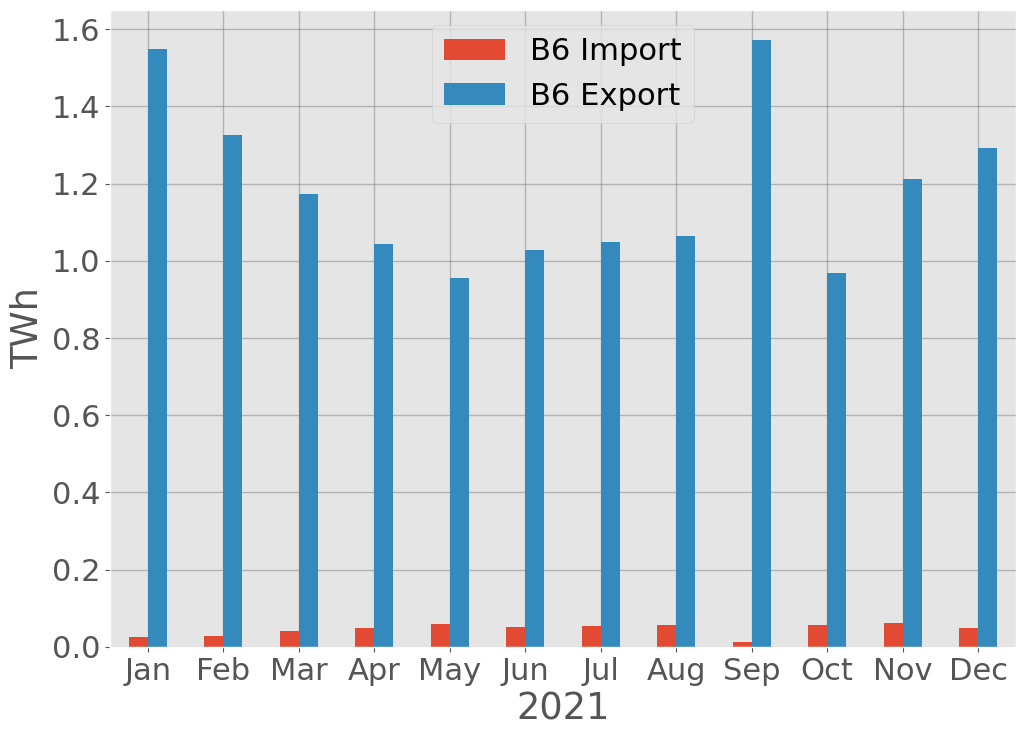

In [15]:
df_import_export = pd.concat([B6_import, B6_export * -1], axis=1) / 1000000
df_import_export.columns = ['B6 Import', 'B6 Export']
df_import_export.to_csv('import_export_2021.csv')
df_import_export = df_import_export.groupby(df_import_export.index.to_period('M')).sum()
df_import_export.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_import_export.plot(kind="bar", rot=0, figsize=(11.69, 8.27))
plt.ylabel('TWh')
plt.xlabel('2021')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)


                     B6 Import  B6 Export  B6 Import  B6 Export
snapshot                                                       
2045-01-01 00:00:00       -0.0   0.002824  -0.000000   0.007040
2045-01-01 01:00:00       -0.0   0.002759  -0.000000   0.007332
2045-01-01 02:00:00       -0.0   0.002727  -0.000000   0.006528
2045-01-01 03:00:00       -0.0   0.002723  -0.000000   0.007229
2045-01-01 04:00:00       -0.0   0.002717   0.000601   0.005493
...                        ...        ...        ...        ...
2045-12-31 19:00:00       -0.0   0.002762  -0.000000   0.005852
2045-12-31 20:00:00       -0.0   0.002707  -0.000000   0.005915
2045-12-31 21:00:00       -0.0   0.002804  -0.000000   0.006024
2045-12-31 22:00:00       -0.0   0.002884  -0.000000   0.005832
2045-12-31 23:00:00       -0.0   0.002907  -0.000000   0.005839

[8760 rows x 4 columns]
                     B6 Import 2021  B6 Export 2021  B6 Import 2045  \
snapshot                                                              
2

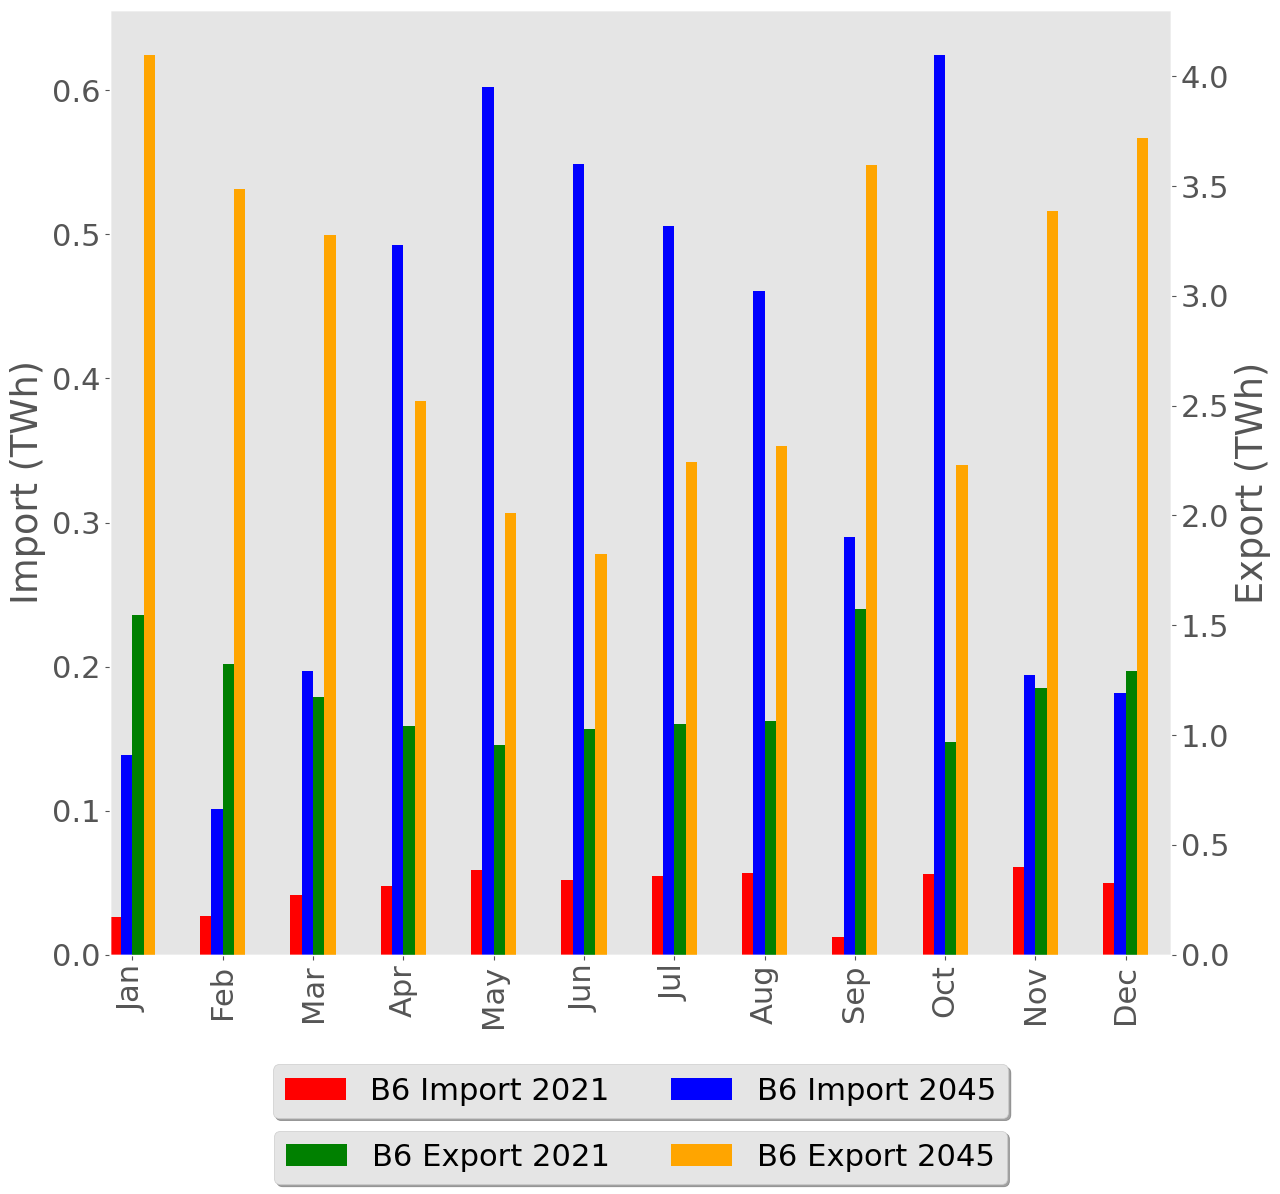

In [4]:
IE_2021 = pd.read_csv('import_export_2021.csv')
IE_2045 = pd.read_csv('import_export_2045.csv')
IE = pd.concat([IE_2021, IE_2045], axis=1)
IE = IE.iloc[: , 1:]
IE.set_index(IE['snapshot'], inplace=True)
IE = IE.drop(columns=['snapshot'])
IE.index = pd.to_datetime(IE.index)
print(IE)
IE.columns = ['B6 Import 2021', 'B6 Export 2021', 'B6 Import 2045', 'B6 Export 2045']
print(IE)

IE = IE.groupby(IE.index.to_period('M')).sum()
IE.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# IE.plot(kind="bar", rot=0, figsize=(11.69, 8.27))
# plt.ylabel('TWh')
# plt.xlabel('2021')
# plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)

fig = plt.figure(figsize=(13.69, 12.27)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.25

IE[['B6 Import 2021', 'B6 Import 2045']].plot(kind='bar', color=['red','blue'], ax=ax, width=width, position=1)
IE[['B6 Export 2021', 'B6 Export 2045']].plot(kind='bar', color=['green', 'orange'], ax=ax2, width=width, position=0)

ax.set_ylabel('Import (TWh)')
ax2.set_ylabel('Export (TWh)')
ax.grid(False)
ax2.grid(False)
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
          fancybox=True, shadow=True, ncol=3)
plt.show()

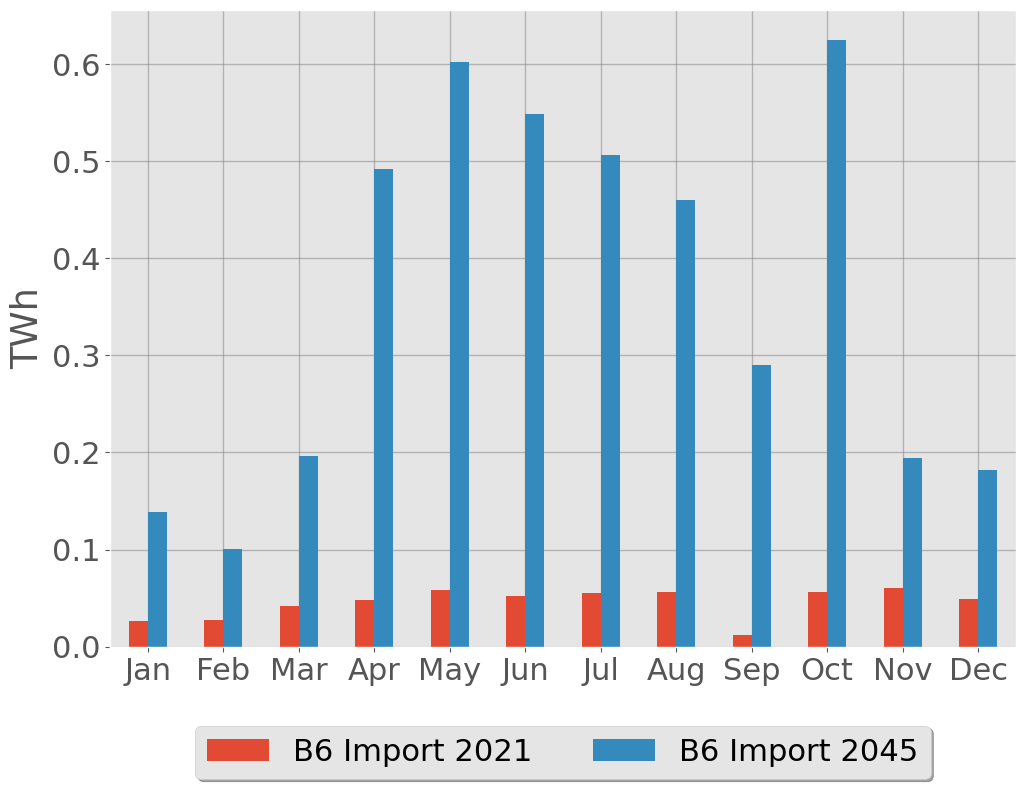

In [5]:
IE_2021 = pd.read_csv('import_export_2021.csv')
IE_2045 = pd.read_csv('import_export_2045.csv')
IE = pd.concat([IE_2021, IE_2045], axis=1)
IE = IE.iloc[: , 1:]
IE.set_index(IE['snapshot'], inplace=True)
IE = IE.drop(columns=['snapshot'])
IE.index = pd.to_datetime(IE.index)
IE.columns = ['B6 Import 2021', 'B6 Export 2021', 'B6 Import 2045', 'B6 Export 2045']

IE = IE.groupby(IE.index.to_period('M')).sum()
IE.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

IE[['B6 Import 2021', 'B6 Import 2045']].plot(kind="bar", rot=0, figsize=(11.69, 8.27))
plt.ylabel('TWh')
# plt.xlabel('2021')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

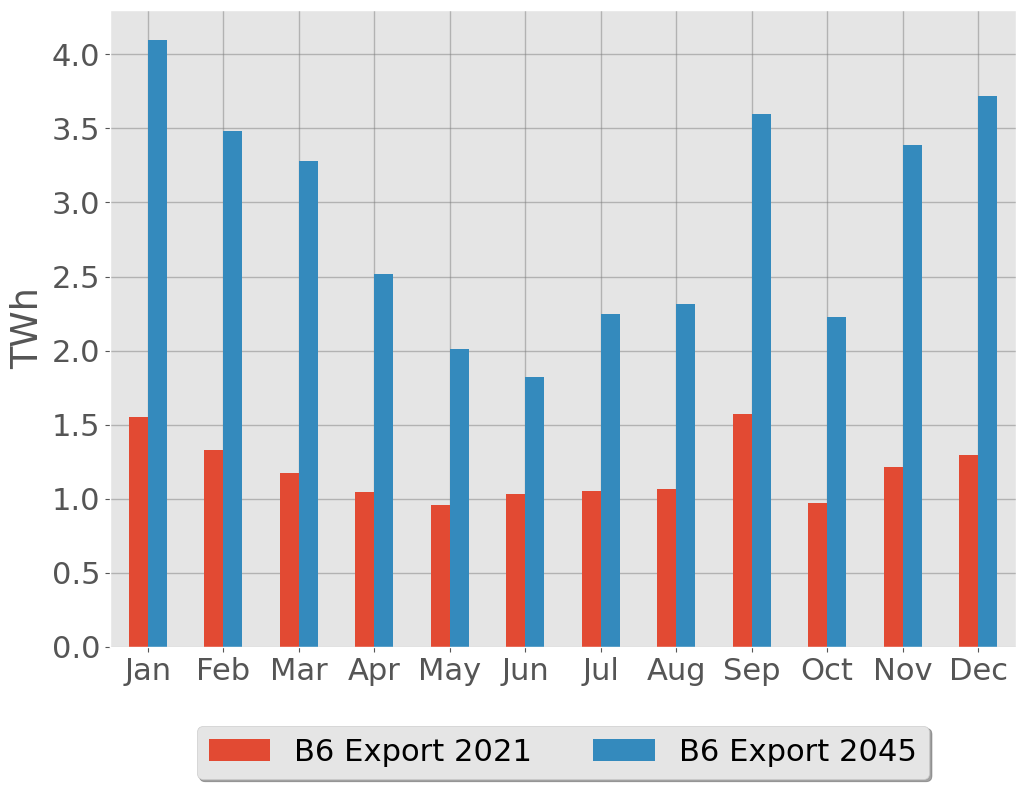

In [6]:
IE_2021 = pd.read_csv('import_export_2021.csv')
IE_2045 = pd.read_csv('import_export_2045.csv')
IE = pd.concat([IE_2021, IE_2045], axis=1)
IE = IE.iloc[: , 1:]
IE.set_index(IE['snapshot'], inplace=True)
IE = IE.drop(columns=['snapshot'])
IE.index = pd.to_datetime(IE.index)
IE.columns = ['B6 Import 2021', 'B6 Export 2021', 'B6 Import 2045', 'B6 Export 2045']

IE = IE.groupby(IE.index.to_period('M')).sum()
IE.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

IE[['B6 Export 2021', 'B6 Export 2045']].plot(kind="bar", rot=0, figsize=(11.69, 8.27))
plt.ylabel('TWh')
# plt.xlabel('2021')
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

In [8]:
IE.sum()

B6 Import 2021     0.542825
B6 Export 2021    14.231520
B6 Import 2045     4.336857
B6 Export 2045    34.705233
dtype: float64